# 0. Data Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Data_Engineering import load_all_matches

In [3]:
#npm install odds-portal-scraper

In [4]:
#npx odds-portal historic premier-league 2020 2023 --local ./data --odds-format eu

In [5]:
df = load_all_matches("data")
df.to_parquet("all_odds.parquet", engine="fastparquet")
print(df.head())
print("Rows:", len(df))

                               match_id         date            home  \
0  09_Dec_2023_Crystal_Palace_Liverpool  09 Dec 2023  Crystal Palace   
1  09_Dec_2023_Crystal_Palace_Liverpool  09 Dec 2023  Crystal Palace   
2  09_Dec_2023_Crystal_Palace_Liverpool  09 Dec 2023  Crystal Palace   
3  09_Dec_2023_Crystal_Palace_Liverpool  09 Dec 2023  Crystal Palace   
4  09_Dec_2023_Crystal_Palace_Liverpool  09 Dec 2023  Crystal Palace   

        away       market   bookmaker outcome  odds  
0  Liverpool  ML_FullTime  Betclic.fr    home  6.75  
1  Liverpool  ML_FullTime  Betclic.fr    draw  4.60  
2  Liverpool  ML_FullTime  Betclic.fr    away  1.43  
3  Liverpool  ML_FullTime     bwin.fr    home  5.75  
4  Liverpool  ML_FullTime     bwin.fr    draw  4.20  
Rows: 39326


# 1. Full Time Arbitrage Detection

In [6]:
arb = []
group = df[df["market"]=="ML_FullTime"]

for match_id, subset in group.groupby("match_id"):

    # get best rows
    best_rows = (
        subset
        .sort_values("odds", ascending=False)
        .groupby("outcome")
        .head(1)
    )

    # extract values
    home_row = best_rows[best_rows["outcome"]=="home"].iloc[0]
    draw_row = best_rows[best_rows["outcome"]=="draw"].iloc[0]
    away_row = best_rows[best_rows["outcome"]=="away"].iloc[0]

    # odds
    home = home_row["odds"]
    draw = draw_row["odds"]
    away = away_row["odds"]
    
    #bookmakers
    home_book = home_row["bookmaker"]
    draw_book = draw_row["bookmaker"]
    away_book = away_row["bookmaker"]
    
    #date
    date = home_row["date"]

    # arbitrage test
    if 1/home + 1/draw + 1/away < 1:
        print("Arbitrage found!", match_id)
        print(" Home:", home_book, home)
        print(" Draw:", draw_book, draw)
        print(" Away:", away_book, away)
        arb.append([match_id,date,home,draw,away,home_book,draw_book,away_book])

arbitrages_ft = pd.DataFrame(arb, columns=['Match','Date','Home','Draw','Away','Home Book','Draw Book','Away Book'])

Arbitrage found! 02_Oct_2021_Chelsea_Southampton
 Home: bwin.fr 1.42
 Draw: Winamax 5.6
 Away: Winamax 11.0
Arbitrage found! 02_Oct_2021_Wolves_Newcastle
 Home: Betclic.fr 1.82
 Draw: Winamax 4.1
 Away: Winamax 5.0
Arbitrage found! 03_Oct_2021_Crystal_Palace_Leicester
 Home: Unibet.fr 3.25
 Draw: Winamax 3.5
 Away: Betclic.fr 2.68
Arbitrage found! 12_Aug_2023_Sheffield_Utd_Crystal_Palace
 Home: Unibet.fr 3.72
 Draw: Betclic.fr 3.2
 Away: Betclic.fr 2.42
Arbitrage found! 14_Aug_2021_Norwich_Liverpool
 Home: Betclic.fr 8.0
 Draw: Betclic.fr 5.2
 Away: Unibet.fr 1.5
Arbitrage found! 14_Aug_2023_Manchester_Utd_Wolves
 Home: Betclic.fr 1.36
 Draw: Unibet.fr 6.15
 Away: Unibet.fr 11.0
Arbitrage found! 15_May_2021_Southampton_Fulham
 Home: Betclic.fr 2.03
 Draw: Winamax 3.8
 Away: Winamax 4.25
Arbitrage found! 19_May_2021_Tottenham_Aston_Villa
 Home: Winamax 1.63
 Draw: Betclic.fr 4.9
 Away: Betclic.fr 5.9
Arbitrage found! 21_Apr_2021_Tottenham_Southampton
 Home: Betclic.fr 1.95
 Draw: Winama

In [7]:
arbitrages_ft["Date"] = pd.to_datetime(arbitrages_ft["Date"])
arbitrages_ft.sort_values("Date", inplace=True)
arbitrages_ft.reset_index(drop=True, inplace=True)
arbitrages_ft.head()

,Match,Date,Home,Draw,Away,Home Book,Draw Book,Away Book
0,21_Apr_2021_Tottenham_Southampton,2021-04-21,1.95,3.85,4.40,Betclic.fr,Winamax,Winamax
1,15_May_2021_Southampton_Fulham,2021-05-15,2.03,3.80,4.25,Betclic.fr,Winamax,Winamax
2,19_May_2021_Tottenham_Aston_Villa,2021-05-19,1.63,4.90,5.90,Winamax,Betclic.fr,Betclic.fr
3,23_May_2021_Fulham_Newcastle,2021-05-23,2.42,3.70,3.50,Unibet.fr,Betclic.fr,Betclic.fr
4,14_Aug_2021_Norwich_Liverpool,2021-08-14,8.00,5.20,1.50,Betclic.fr,Betclic.fr,Unibet.fr


# 2. Backtesting Full Time Strategy
We bet start with 1000 and bet .5 of our wealth each time. <br>
We bet so that we get the same payoff no matter the payoff, that means if we bet $B$ total, divided in $s_1$, $s_2$, $s_3$, with resp. odds $o_1$, $o_2$, $o_3$, we want $s_1o_1 = s_2o_2 = s_3o_3 = K$. <br>
Then $B = s_1+s_2+s_3 = K(1/o_1 + 1/o_2 + 1/o_3)$ and $K = B/(1/o_1 + 1/o_2 + 1/o_3)$. <br>
Then $s_i = K/o_i = B/(o_i(1/o_1 + 1/o_2 + 1/o_3))$.

### This is a simplified Arbitrage model !
- Here, the PnL is deterministic, it doesn't depend on the outcome, it is risk free. <br>
- There is no transaction costs. <br>
- We assume instant settlement and therefore no capital locked, we can't do unlimited parallel arbitrage (in reality, the capital is locked for at least 90 minutes). <br>
- No bet refusal <br>
- Most important, no latency so the odds don't change while placing the bets. 

In [41]:
initial_wealth = 1000
stake = 0.9

In [42]:
df['date'] = pd.to_datetime(df['date'])

start = df["date"].min()
end   = df["date"].max()

all_dates = pd.date_range(start, end, freq="D")

In [43]:
wealth_history = pd.DataFrame(index=all_dates, columns=["Wealth"])
wealth = initial_wealth
wealth_history.iloc[0,0] = wealth

for i in range(len(arbitrages_ft)):
    date_i = arbitrages_ft.loc[i, "Date"]

    bet = wealth * stake
    edge = 1/(1/arbitrages_ft.loc[i,'Home'] + 1/arbitrages_ft.loc[i,'Draw'] + 1/arbitrages_ft.loc[i,'Away']) - 1
    wealth = wealth + bet*edge

    wealth_history.loc[date_i, "Wealth"] = wealth 

wealth_history["Wealth"] = wealth_history["Wealth"].ffill()

wealth_history.sort_index(inplace=True)


/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_3090/927577.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wealth_history["Wealth"] = wealth_history["Wealth"].ffill()


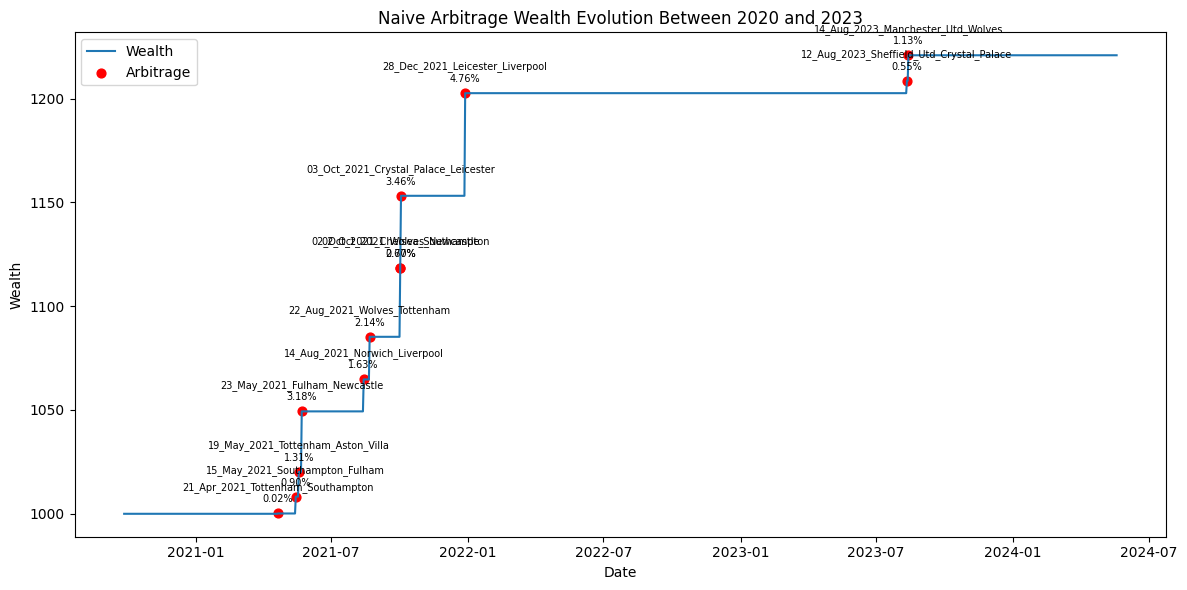

In [56]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(wealth_history.index, wealth_history["Wealth"], label="Wealth")

arb_dates = arbitrages_ft["Date"]
arb_wealth = wealth_history.loc[arb_dates, "Wealth"]

ax.scatter(arb_dates, arb_wealth, color="red", s=40, label="Arbitrage")

for i in range(len(arbitrages_ft)):
    date_i = arbitrages_ft.loc[i, "Date"]
    wealth_i = wealth_history.loc[date_i, "Wealth"]

    h = arbitrages_ft.loc[i,"Home"]
    d = arbitrages_ft.loc[i,"Draw"]
    a = arbitrages_ft.loc[i,"Away"]
    edge = 1/(1/h + 1/d + 1/a) - 1

    match_name = arbitrages_ft.loc[i, "Match"]
    label = f"{match_name}\n{edge*100:.2f}%"

    ax.annotate(
        label,
        (date_i, wealth_i),
        xytext=(0, 8),
        textcoords="offset points",
        ha='center',
        fontsize=7,
        color='black'
    )

ax.legend()
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.title('Naive Arbitrage Wealth Evolution Between 2020 and 2023')
plt.tight_layout()
plt.show()

## Performance Evaluation

In [45]:
returns = wealth_history["Wealth"].pct_change().dropna()
rf = 0.03
rf_daily = rf / 365

In [46]:
mean_return = returns.mean()
std_return  = returns.std()

sharpe_ratio = (mean_return - rf_daily) / std_return * (365**0.5)
sharpe_ratio

np.float64(0.6593849191220561)

In [47]:
print("Sharpe:", sharpe_ratio)

Sharpe: 0.6593849191220561


In [48]:
Return = (wealth_history.iloc[-1]['Wealth']-wealth_history.iloc[0]['Wealth'])/wealth_history.iloc[0]['Wealth']
print("Return:", Return)

Return: 0.22083345000193366
